### SparkSQL
- Spark가 지원하는 Spark 전용 SQL

#### .createOrReplaceTempView(뷰이름)
#### .createTempView(뷰이름)
- SQL statement를 실행하기 위하여 DataFrame을 뷰(가상 테이블)로 변환
- 해당 뷰는 sparksession이 실행되는 동안 존재
- 해당 뷰의 삭제 : spark.catalog.dropTempView("name")

#### .createGlobalTempView
- 해당 뷰는 spark이 실행되는 동안 존재
- 해당 뷰의 삭제 : spark.catalog.dropGlobalTempView("name")

-> .registerTempTable을 대체

In [1]:
import findspark

In [2]:
findspark.init()

In [3]:
import pyspark

In [4]:
import pyspark.sql

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.master("local").getOrCreate()

In [8]:
sc = spark.sparkContext

In [9]:
linesDF = spark  \
.read  \
.format("csv")  \
.option("encoding", "EUC-kr")  \
.option("sep", "\n")  \
.load("C://spark/data/review.txt")

In [10]:
import re

In [13]:
wcRDD = linesDF  \
.rdd  \
.map(lambda line: line[0])  \
.flatMap(lambda line: re.split("\W+", line))  \
.filter(lambda word: len(word) > 0)  \
.map(lambda word: (word, 1))  \
.reduceByKey(lambda v1, v2: v1 + v2)  \
.sortBy(lambda wc: wc[1], False)

In [14]:
wc50RDD = sc.parallelize(wcRDD.take(50))

In [15]:
wc50DF = spark.createDataFrame(wc50RDD)

In [16]:
wc50DF.show(3)

+----+----+
|  _1|  _2|
+----+----+
|영화|1346|
|너무| 898|
|정말| 698|
+----+----+
only showing top 3 rows



In [23]:
wc50DF.createOrReplaceTempView("wcTable")

In [24]:
wcDFlength = spark.sql("select _1 as words, _2 as freq, length(_1) as wordLen from wcTable")

In [25]:
wcDFlength.show(3)

+-----+----+-------+
|words|freq|wordLen|
+-----+----+-------+
| 영화|1346|      2|
| 너무| 898|      2|
| 정말| 698|      2|
+-----+----+-------+
only showing top 3 rows



In [26]:
wcDFlength.createOrReplaceTempView("wcDFlengthTable")

단어길이별 평균 발생빈도를 계산해서 긴 단어와 짧은 단어 중 어떤 것이 많이 나타나는지의 차이가 있는가를 검증

In [27]:
wordLengthFrequency = spark.sql("select wordLen, count(freq), avg(freq)  \
                                 from wcDFlengthTable  \
                                 group by wordLen  \
                                 order by wordLen")

In [28]:
spark.sql("select words  \
           from wcDFlengthTable  \
           where wordLen = 1  \
           order by words").show()

+-----+
|words|
+-----+
|   것|
|   그|
|   꼭|
|   다|
|   더|
|   또|
|   본|
|   수|
|   이|
|   잘|
|   좀|
|   한|
+-----+



In [29]:
spark.sql("select words, freq  \
           from wcDFlengthTable  \
           where wordLen = 1  \
           order by words").show()

+-----+----+
|words|freq|
+-----+----+
|   것| 150|
|   그| 213|
|   꼭| 285|
|   다| 179|
|   더| 342|
|   또| 129|
|   본| 154|
|   수| 277|
|   이| 255|
|   잘| 518|
|   좀| 209|
|   한| 197|
+-----+----+



단어 길이별 평균 프리컨시와 발생빈도를 그래프로 표시

In [30]:
import numpy as np

In [31]:
import matplotlib.pyplot as plt

In [32]:
x = wordLengthFrequency.select(F.col("wordLen")).collect()

In [33]:
type(x)

list

In [34]:
for e in x:
    print(e)

Row(wordLen=1)
Row(wordLen=2)
Row(wordLen=3)
Row(wordLen=4)
Row(wordLen=5)


In [35]:
xA = np.array(x)

In [36]:
xA[0:2]

array([[1],
       [2]])

In [39]:
xA1 = np.ravel(xA)

In [40]:
xA1[0:2]

array([1, 2])

In [41]:
y1 = wordLengthFrequency.select(F.col("count(freq)")).collect()

In [42]:
y1[0:2]

[Row(count(freq)=12), Row(count(freq)=17)]

In [43]:
y1A = np.array(y1)

In [44]:
y1A.ndim

2

In [54]:
y1A1 = np.ravel(y1A)

In [46]:
y2 = wordLengthFrequency.select(F.col("avg(freq)")).collect()

In [47]:
y2A = np.array(y2)

In [49]:
y2A1 = np.ravel(y2A)

In [50]:
from matplotlib import font_manager

No handles with labels found to put in legend.


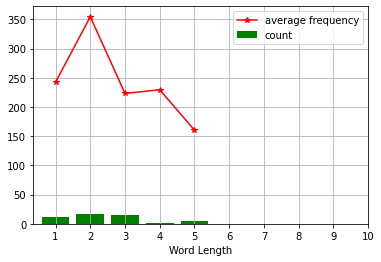

In [56]:
plt.bar(xA1, y1A1, color="green")
plt.plot(xA1, y2A1, marker='*', color='red')
plt.legend()
plt.xlabel("Word Length")
plt.xticks(range(1,11))
plt.grid(True)
plt.legend(['average frequency', 'count'])
plt.show()